In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [ ]:
last_data = pd.read_csv('/content/gdrive/MyDrive/CIC-ids2017-cleaned_version.csv')

In [ ]:
y_labels = last_data.Label.value_counts().index



---



---



In [ ]:
!pip install pytorch-tabnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 443.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 68.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 73.0 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1+cu118
    Uninstalling torch-2.0.1+cu118:
      Successfully uninstalled torch-2.0.1+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.0.2+cu118 requires torch==2.0.1, but you have torch 1.13.1 wh

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# we split the data to x, labels
X = last_data.drop(['Label', 'Destination Port', 'Flow Duration'], axis=1)
y= last_data['Label']


labelencoder = LabelEncoder()
# next we encode the label in y to numerical values
y = labelencoder.fit_transform(y)
print('----------------\n')
print(np.unique(y))
print('----------------\n')

# lastly we split the datas into training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.2,random_state =0)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test,test_size=.2,random_state =0)

#from sklearn import preprocessing
#X_train = preprocessing.normalize(X_train)

----------------

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
----------------



In [ ]:
!pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter

In [ ]:
# summarize distribution
counter = Counter(y_train)
for k,v in counter.items():
 per = v / len(y) * 100
 print('Class=%d, n=%d (%.3f%%)'%(k, v, per))

Class=0, n=1816652 (64.241%)
Class=4, n=184080 (6.509%)
Class=10, n=127236 (4.499%)
Class=2, n=102608 (3.628%)
Class=3, n=8263 (0.292%)
Class=7, n=6315 (0.223%)
Class=6, n=4633 (0.164%)
Class=11, n=4737 (0.168%)
Class=5, n=4447 (0.157%)
Class=14, n=527 (0.019%)
Class=1, n=1550 (0.055%)
Class=12, n=1198 (0.042%)
Class=8, n=8 (0.000%)
Class=13, n=17 (0.001%)
Class=9, n=29 (0.001%)


In [ ]:
del last_data

In [ ]:
del X,y

In [ ]:

strategy_ov = {0:1816652, 4:184080, 10:127236, 2:102608, 3:10000, 7:10000, 6:10000, 11:10000, 5:10000, 14: 1000, 1:1550, 12:1198, 8:500, 13:500, 9:500}
strategy_un = {0:400000, 4:184080, 10:127236, 2:102608, 3:10000, 7:10000, 6:10000, 11:10000, 5:10000, 14: 1000, 1:1550, 12:1198, 8:500, 13:500, 9:500}

# define pipeline
over = SMOTE(sampling_strategy=strategy_ov)
under = RandomUnderSampler(sampling_strategy=strategy_un)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
x2, y2 = pipeline.fit_resample(X_train, y_train)

# summarize the new class distribution
counter = Counter(y2)
print(counter)

Counter({0: 400000, 4: 184080, 10: 127236, 2: 102608, 3: 10000, 5: 10000, 6: 10000, 7: 10000, 11: 10000, 1: 1550, 12: 1198, 14: 1000, 8: 500, 9: 500, 13: 500})


In [ ]:
del pipeline, under, over

In [ ]:
# normalization
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
train_sc = scaler.fit_transform(X_train)

valid_sc = scaler.transform(X_val)
test_sc = scaler.transform(X_test)



---



---



# trained without the SMOTE technique and standarisation

In [ ]:
import torch
device = torch.device('cuda')

In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier

model_path = 'path/to/tabnet_model.pth'
model = TabNetClassifier()
model.load_model(model_path)

In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier

clf = TabNetClassifier(device_name='cuda')  #TabNetRegressor()
clf.fit(
  X_train.values, y_train,
  eval_set=[(X_val.values, y_val)],
  weights=1
)
preds = clf.predict(X_test.values)

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.3662  | val_0_accuracy: 0.73935 |  0:01:43s
epoch 1  | loss: 0.25125 | val_0_accuracy: 0.79481 |  0:03:21s
epoch 2  | loss: 0.24399 | val_0_accuracy: 0.78283 |  0:04:58s
epoch 3  | loss: 0.23129 | val_0_accuracy: 0.78033 |  0:06:34s
epoch 4  | loss: 0.22995 | val_0_accuracy: 0.7095  |  0:08:12s
epoch 5  | loss: 0.22478 | val_0_accuracy: 0.74376 |  0:09:49s
epoch 6  | loss: 0.22053 | val_0_accuracy: 0.78485 |  0:11:26s
epoch 7  | loss: 0.21106 | val_0_accuracy: 0.75094 |  0:13:03s
epoch 8  | loss: 0.22044 | val_0_accuracy: 0.734   |  0:14:39s
epoch 9  | loss: 0.2077  | val_0_accuracy: 0.7927  |  0:16:14s
epoch 10 | loss: 0.20364 | val_0_accuracy: 0.78921 |  0:17:50s
epoch 11 | loss: 0.19994 | val_0_accuracy: 0.89677 |  0:19:25s
epoch 12 | loss: 0.19951 | val_0_accuracy: 0.82157 |  0:21:01s
epoch 13 | loss: 0.19538 | val_0_accuracy: 0.83916 |  0:22:37s
epoch 14 | loss: 0.19481 | val_0_accuracy: 0.80488 |  0:24:12s
epoch 15 | loss: 0.19252 | val_0_accuracy: 0.8291  |  0

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:
# save tabnet model
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_model_test_1.zip


In [ ]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, preds))
print("f1-score:",metrics.f1_score(y_test, preds, average=None))
print("recall:",metrics.recall_score(y_test, preds, average=None))

Accuracy: 0.8968328692039075
f1-score: [0.93580952 0.04645761 0.97925455 0.88733291 0.81393753 0.40546006
 0.55084476 0.6471173  0.66666667 0.01865672 0.8812384  0.2257327
 0.05492456 0.02352941 0.06042595]
recall: [0.91007226 1.         0.97139622 0.86049383 0.69017135 0.48313253
 0.92406417 0.49280848 1.         0.83333333 0.99853169 0.58512931
 0.62790698 0.66666667 0.67032967]


In [ ]:
from sklearn import metrics
# function for plotting
def evaluating(y_pred, y_test):
  print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

  plt.figure(figsize=(10,5))

  plt.bar(y_labels,metrics.f1_score(y_test, preds, average=None))
  #to add the values in the bar chart
  addlabels(y_labels, metrics.f1_score(y_test, preds, average=None))

  plt.xticks(rotation=90)

  # giving X and Y labels
  plt.xlabel("Attacks")
  plt.ylabel("F1-score")

  plt.show()

Accuracy: 0.8968328692039075


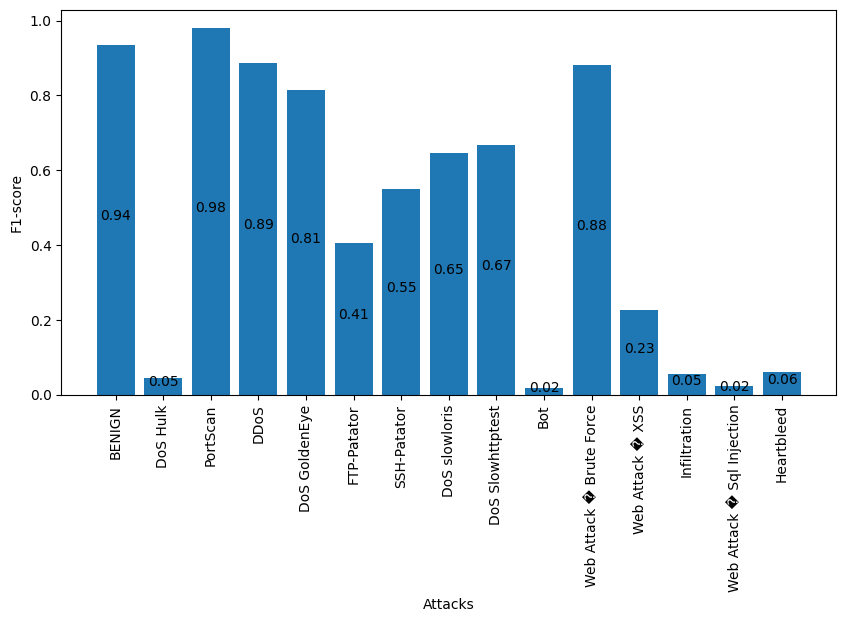

In [ ]:
evaluating(preds, y_test)

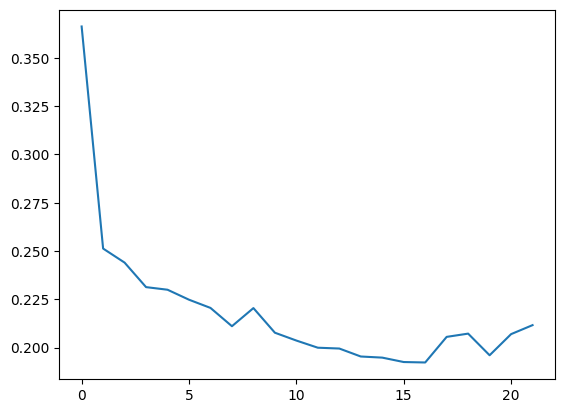

In [ ]:
plt.plot(clf.history['loss'])

## explainability

In [ ]:
clf.feature_importances_

array([8.43768213e-02, 0.00000000e+00, 3.24196559e-03, 0.00000000e+00,
       3.74082575e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.04859100e-03, 1.60839628e-01, 5.46128750e-02, 0.00000000e+00,
       4.09301438e-02, 0.00000000e+00, 0.00000000e+00, 5.93391278e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.51287160e-02,
       0.00000000e+00, 2.37133797e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.59918838e-04, 8.51977654e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.32485774e-01,
       1.33599230e-02, 2.28601513e-03, 1.96790557e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.08697715e-02,
       0.00000000e+00, 9.35775833e-03, 9.40380396e-04, 7.72982851e-03,
       0.00000000e+00, 6.03585748e-02, 1.84632880e-01, 0.00000000e+00,
       0.00000000e+00, 1.39214731e-05, 0.00000000e+00, 1.02705169e-02,
      

In [ ]:
explain_matrix, masks = clf.explain(X_test.values)

In [ ]:
masks[].shape

(452460, 67)

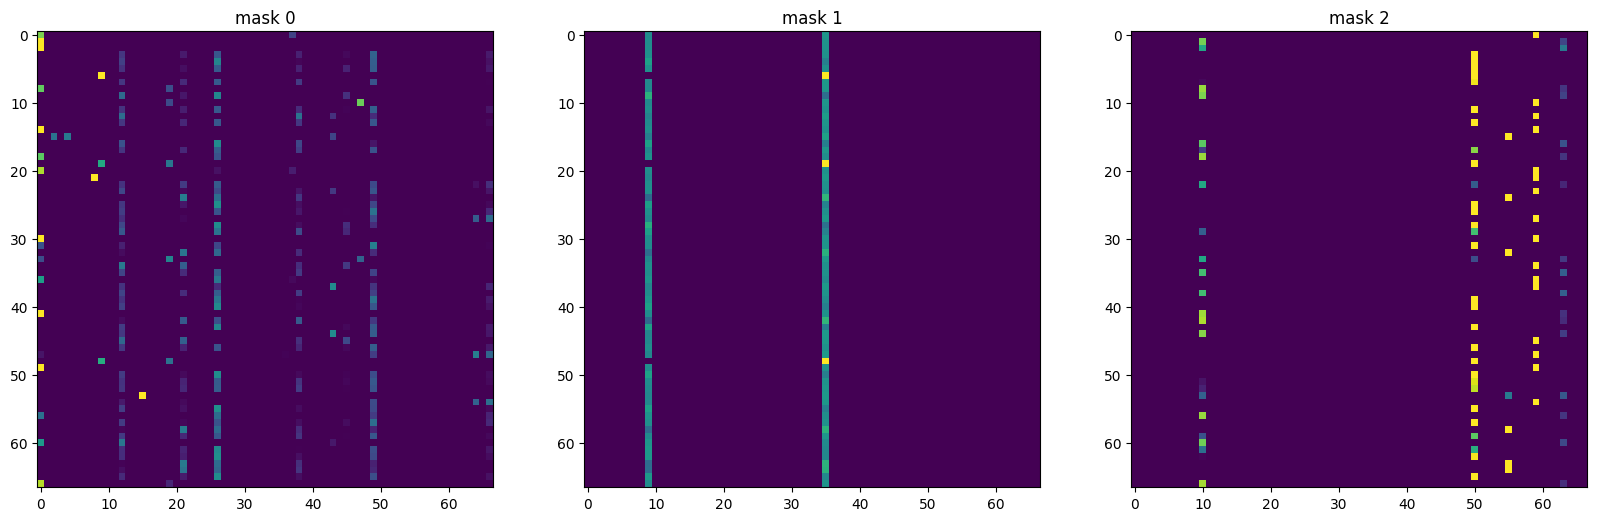

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:67])
    axs[i].set_title(f"mask {i}")



---



---



# with the Smote and standarisation

In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier

clf = TabNetClassifier(device_name='cuda')  #TabNetRegressor()
clf.fit(
  train_sc, y2,
  eval_set=[(valid_sc, y_val)],
  weights=1
)
preds = clf.predict(test_sc)

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.46389 | val_0_accuracy: 0.72615 |  0:00:41s
epoch 1  | loss: 0.27395 | val_0_accuracy: 0.74587 |  0:01:21s
epoch 2  | loss: 0.25969 | val_0_accuracy: 0.79799 |  0:02:00s
epoch 3  | loss: 0.24031 | val_0_accuracy: 0.77834 |  0:02:41s
epoch 4  | loss: 0.23688 | val_0_accuracy: 0.80275 |  0:03:21s
epoch 5  | loss: 0.23348 | val_0_accuracy: 0.80345 |  0:04:00s
epoch 6  | loss: 0.2257  | val_0_accuracy: 0.8329  |  0:04:39s
epoch 7  | loss: 0.22442 | val_0_accuracy: 0.82151 |  0:05:20s
epoch 8  | loss: 0.22283 | val_0_accuracy: 0.86949 |  0:05:59s
epoch 9  | loss: 0.22067 | val_0_accuracy: 0.83278 |  0:06:38s
epoch 10 | loss: 0.21815 | val_0_accuracy: 0.80598 |  0:07:18s
epoch 11 | loss: 0.2147  | val_0_accuracy: 0.82257 |  0:07:57s
epoch 12 | loss: 0.21201 | val_0_accuracy: 0.82591 |  0:08:35s
epoch 13 | loss: 0.21578 | val_0_accuracy: 0.85694 |  0:09:15s
epoch 14 | loss: 0.2113  | val_0_accuracy: 0.85839 |  0:09:54s
epoch 15 | loss: 0.20997 | val_0_accuracy: 0.81859 |  0

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:
# save tabnet model
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_model_test_1.zip


In [ ]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, preds))
print("f1-score:",metrics.f1_score(y_test, preds, average=None))
print("recall:",metrics.recall_score(y_test, preds, average=None))

Accuracy: 0.8685209742297662
f1-score: [0.91431229 0.05911424 0.77305499 0.76074499 0.87456105 0.71378709
 0.67069943 0.93566833 0.44444444 0.         0.90173015 0.09310134
 0.19278169 0.00255428 0.00308642]
recall: [0.86757751 0.971875   0.63080937 0.98333333 0.90672117 0.98554217
 0.9486631  0.99091597 1.         0.         0.99484107 0.98599138
 0.84883721 0.66666667 0.05494505]


Accuracy: 0.8685209742297662


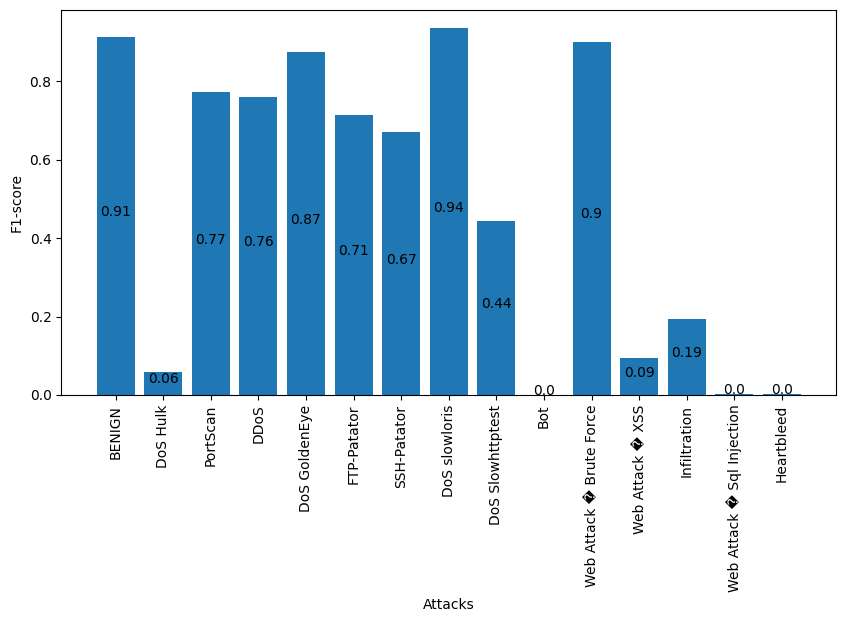

In [ ]:
evaluating(preds, y_test)

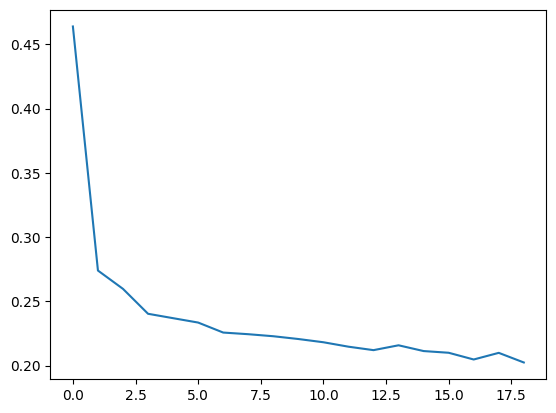

In [ ]:
plt.plot(clf.history['loss'])



---



---



# with standiration and without smote

In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier

clf = TabNetClassifier(device_name='cuda')  #TabNetRegressor()
clf.fit(
  train_sc, y_train,
  eval_set=[(valid_sc, y_val)],
  weights=1
)
preds = clf.predict(test_sc)

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.37451 | val_0_accuracy: 0.80151 |  0:01:43s
epoch 1  | loss: 0.24182 | val_0_accuracy: 0.78423 |  0:03:24s
epoch 2  | loss: 0.22311 | val_0_accuracy: 0.79668 |  0:05:02s
epoch 3  | loss: 0.2105  | val_0_accuracy: 0.83779 |  0:06:40s
epoch 4  | loss: 0.20817 | val_0_accuracy: 0.81721 |  0:08:17s
epoch 5  | loss: 0.20426 | val_0_accuracy: 0.82937 |  0:09:54s
epoch 6  | loss: 0.19705 | val_0_accuracy: 0.78054 |  0:11:31s
epoch 7  | loss: 0.19331 | val_0_accuracy: 0.80552 |  0:13:08s
epoch 8  | loss: 0.18884 | val_0_accuracy: 0.89203 |  0:14:45s
epoch 9  | loss: 0.19682 | val_0_accuracy: 0.78816 |  0:16:22s
epoch 10 | loss: 0.19115 | val_0_accuracy: 0.88004 |  0:17:57s
epoch 11 | loss: 0.20009 | val_0_accuracy: 0.85082 |  0:19:32s
epoch 12 | loss: 0.18249 | val_0_accuracy: 0.83445 |  0:21:07s
epoch 13 | loss: 0.19424 | val_0_accuracy: 0.8511  |  0:22:43s
epoch 14 | loss: 0.17884 | val_0_accuracy: 0.83107 |  0:24:17s
epoch 15 | loss: 0.1731  | val_0_accuracy: 0.81573 |  0

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:
# took 41min to train
# save tabnet model
saving_path_name = "./tabnet_89.203_without_SMOTE_with_standarisation"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_89.203_without_SMOTE_with_standarisation.zip


In [ ]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, preds))
print("f1-score:",metrics.f1_score(y_test, preds, average=None))
print("recall:",metrics.recall_score(y_test, preds, average=None))

Accuracy: 0.8905184988728285
f1-score: [0.93200875 0.13067267 0.769961   0.25166497 0.80262856 0.66178266
 0.37358368 0.48084641 0.25       0.00997009 0.89451281 0.65526676
 0.06527652 0.00174444 0.06407487]
recall: [0.91948132 0.634375   0.62692005 0.99135802 0.70917359 0.97951807
 0.6171123  0.4988645  0.5        0.83333333 0.99658717 0.51616379
 0.13953488 0.66666667 0.97802198]


Accuracy: 0.8905184988728285


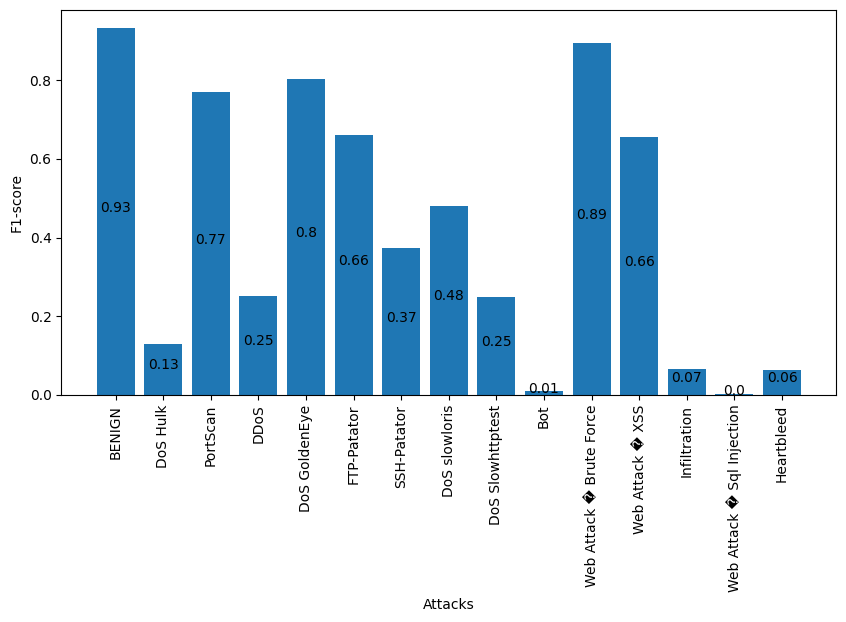

In [ ]:
evaluating(preds, y_test)

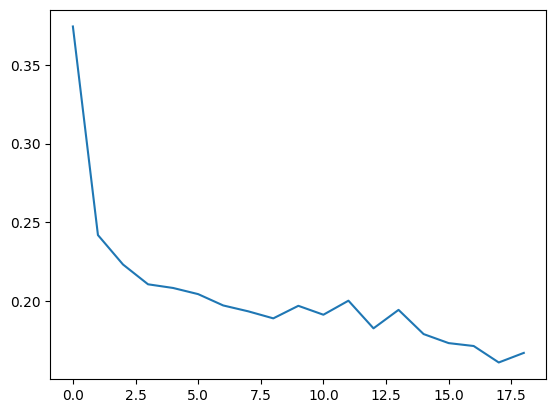

In [ ]:
plt.plot(clf.history['loss'])



---



---



# ML tests with robust scaler

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# we split the data to x, labels
X = last_data.drop(['Label', 'Destination Port', 'Flow Duration'], axis=1)
y= last_data['Label']


labelencoder = LabelEncoder()
# next we encode the label in y to numerical values
y = labelencoder.fit_transform(y)
print('----------------\n')
print(np.unique(y))
print('----------------\n')

# lastly we split the datas into training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.2,random_state =0)


#from sklearn import preprocessing
#X_train = preprocessing.normalize(X_train)

----------------

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
----------------



In [ ]:
!pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter

In [ ]:

strategy_ov = {0:1816652, 4:184080, 10:127236, 2:102608, 3:10000, 7:10000, 6:10000, 11:10000, 5:10000, 14: 1000, 1:1550, 12:1198, 8:500, 13:500, 9:500}
strategy_un = {0:400000, 4:184080, 10:127236, 2:102608, 3:10000, 7:10000, 6:10000, 11:10000, 5:10000, 14: 1000, 1:1550, 12:1198, 8:500, 13:500, 9:500}

# define pipeline
over = SMOTE(sampling_strategy=strategy_ov)
under = RandomUnderSampler(sampling_strategy=strategy_un)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
x2, y2 = pipeline.fit_resample(X_train, y_train)

# summarize the new class distribution
counter = Counter(y2)
print(counter)

Counter({0: 400000, 4: 184080, 10: 127236, 2: 102608, 3: 10000, 5: 10000, 6: 10000, 7: 10000, 11: 10000, 1: 1550, 12: 1198, 14: 1000, 8: 500, 9: 500, 13: 500})


In [ ]:
# normalization
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
train_sc = scaler.fit_transform(x2)

test_sc = scaler.transform(X_test)

In [ ]:
import time
#function for the training
def training_route(modell, x_train, y_train, x_test):
  t0 = time.time()
  modell = modell.fit(x_train, y_train)
  print("Training time:", time.time()-t0)
  return modell.predict(x_test)

In [ ]:
# function to add text to the plot
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]/2, round(y[i],2), ha = 'center')

In [ ]:
from sklearn import metrics
# function for plotting
def evaluating(y_pred, y_test):
  print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

  plt.figure(figsize=(10,5))

  plt.bar(y_labels,metrics.f1_score(y_test, y_pred, average=None))
  #to add the values in the bar chart
  addlabels(y_labels, metrics.f1_score(y_test, y_pred, average=None))

  plt.xticks(rotation=90)

  # giving X and Y labels
  plt.xlabel("Attacks")
  plt.ylabel("F1-score")

  plt.show()

In [ ]:
y_labels = last_data.Label.value_counts().index

Training time: 50.52175331115723
Accuracy: 0.9982053693933265


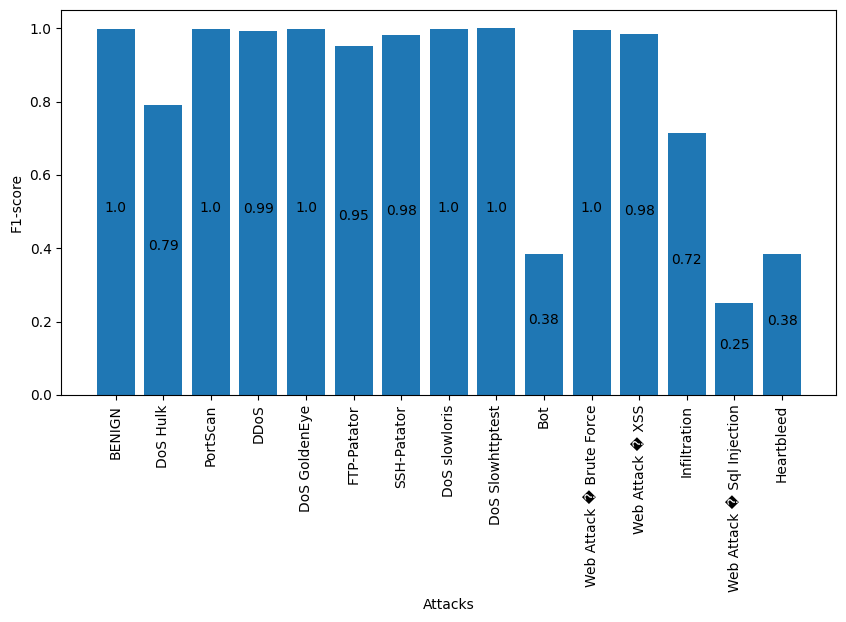

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

y_pred = training_route(DecisionTreeClassifier(random_state=0), train_sc, y2, test_sc)

evaluating(y_pred, y_test)
# could argu that it is the best with robust scaler

Training time: 214.1923110485077
Accuracy: 0.9982230504830474


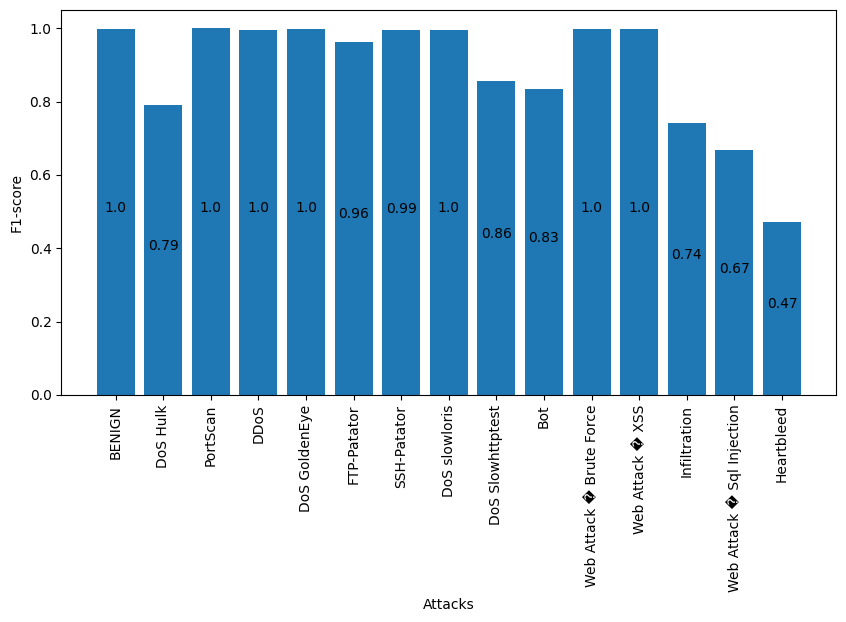

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=50, class_weight='balanced', random_state=0)
y_pred = training_route(clf, train_sc, y2, test_sc)

evaluating(y_pred, y_test)
# the best result yet with robustscaler

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 1135.0213429927826
Accuracy: 0.10008557647424926


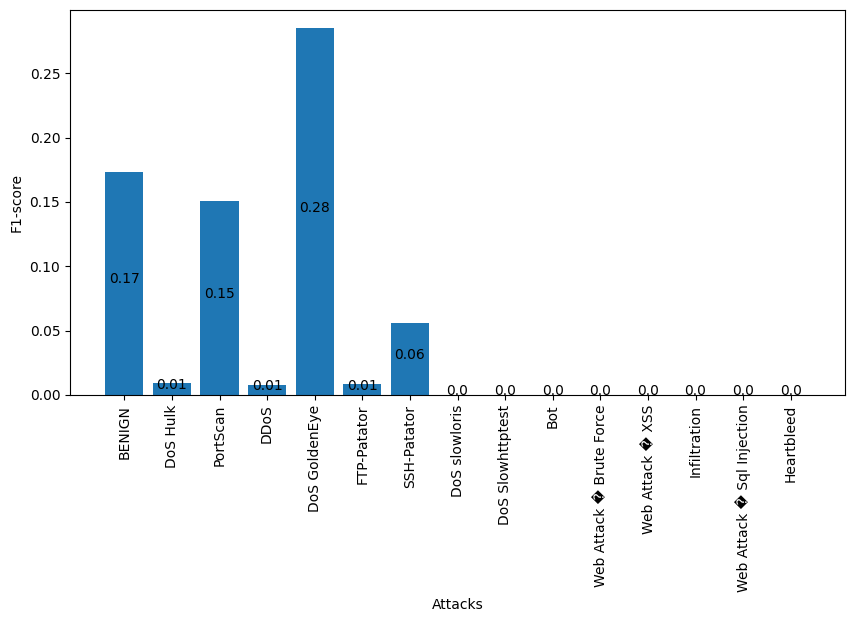

In [ ]:
from sklearn.linear_model import LogisticRegression
# define model
clf = LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=1000)
y_pred = training_route(clf, train_sc, y2, test_sc)

evaluating(y_pred, y_test)

Training time: 1806.6373083591461
Accuracy: 0.9767352221452112


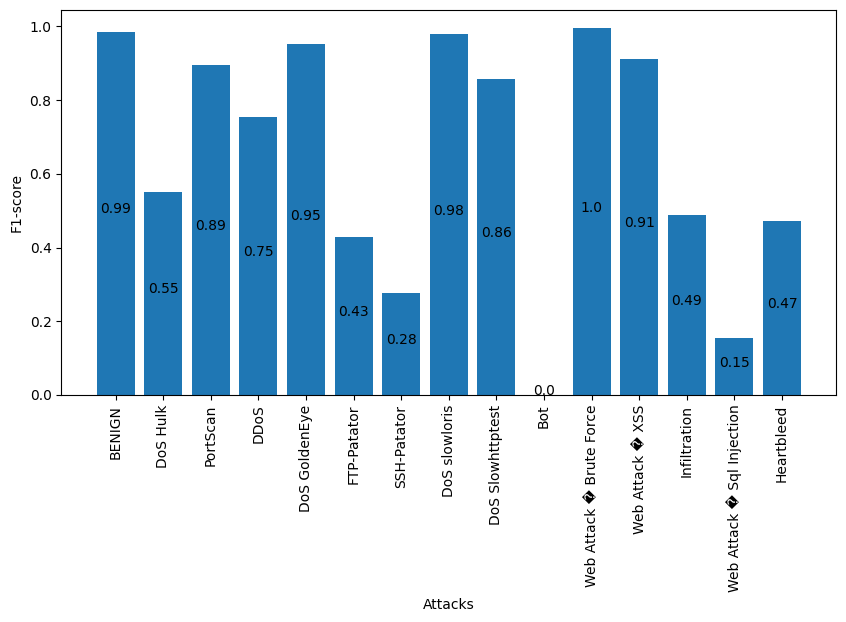

In [ ]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=1, max_iter=300)
y_pred = training_route(clf, train_sc, y2, test_sc)

evaluating(y_pred, y_test)

In [ ]:
from xgboost import XGBClassifier
cc = XGBClassifier(random_state=0)
y_pred = training_route(cc, train_sc, y2, test_sc)

evaluating(y_pred, y_test)